In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from sklearn.manifold import TSNE
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
import sys
sys.path.append("..")
from src.glove import GloveWordsDataset, GloveModel

from collections import Counter

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
# from gensim.models import Word2Vec
import gensim.downloader
from gensim.models import KeyedVectors

import re
import string


In [7]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [8]:
ROOT_PATH = '/Users/pafitis/dev/comp0087/nlp-project-2021/'

device = 'cpu'

In [9]:
_stopwords = stopwords.words('english')
_lemmatizer = WordNetLemmatizer()
_stemmer = PorterStemmer()

model = KeyedVectors.load_word2vec_format('/Users/pafitis/dev/comp0087/nlp-project-2021/datasets/word2vec/GoogleNews-vectors-negative300.bin', binary = True)

textfile = "../datasets/glove/train_set_uk.txt"

In [10]:
def _cleanup(token):
    x = token.encode('ascii', 'ignore').decode().lower()
    x = re.sub(r'https*\S+', ' ', x)
    # x = re.sub(r'@\S+', ' ', x)
    # x = re.sub(r'#\S+', ' ', x)
    x = re.sub(r'\'\w+', ' ', x)
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    # x = re.sub(r'\w*\d+\w*', ' ', x)
    x = re.sub(r'\s{2,}', ' ', x)
    return x

def word2vec_embeddings(PATH, top_k = 200):

    _input = pd.read_table(PATH, header = None)
    _alltext = _input.values[0][0]
    out = _alltext.split(' ')

    out = [remove_stopwords(x) for x in out]
    out = [x for x in out if x != '']

    cleaned = [_cleanup(w) for w in out]
    filtered = [w for w in cleaned if len(w) > 2 if not w in _stopwords]
    # I am removing stemming as I dont know how the preprocessing was done
    # reading the README does not indicate what was done exactly
    # stemmed = [_stemmer.stem(w) for w in filtered] 
    # lemmatized = [_lemmatizer.lemmatize(w) for w in stemmed]

    lemmatized = [_lemmatizer.lemmatize(w) for w in filtered]
    final = [''.join(w.split(' ')) for w in lemmatized]

    word_counter = Counter()
    word_counter.update(final)

    most_common = [x[0] for x in word_counter.most_common(top_k)]

    embeddings = [model[x] if x in model.key_to_index else np.repeat(-1, 300) for x in most_common]
    embeddings = np.vstack(embeddings)

    return most_common, embeddings


def plot_tsne(words, embeds, title):
    tsne = TSNE(metric='cosine', random_state=123)
    # Call TSNE fit on only those top 500
    embed_tsne = tsne.fit_transform(embeds)

    fig, ax = plt.subplots(1, 1, figsize = (15, 15))
    plt.suptitle(title)
    for word, emb in zip(words, embed_tsne):
        
        plt.scatter(*emb, color = 'red')
        plt.annotate(word, (emb[0], emb[1]), alpha = 0.6)
    plt.tight_layout()
    plt.axis('off')
    plt.show()


In [21]:
from nltk import str2tuple
from nltk import pos_tag

In [139]:
def get_tokens(PATH):
    _input = pd.read_table(PATH, header = None)
    _alltext = _input.values[0][0]
    out = _alltext.split(' ')

    out = [remove_stopwords(x) for x in out]
    out = [x for x in out if x != '']

    cleaned = [_cleanup(w) for w in out]
    filtered = [w for w in cleaned if len(w) > 2 if not w in _stopwords]
    # I am removing stemming as I dont know how the preprocessing was done
    # reading the README does not indicate what was done exactly
    # stemmed = [_stemmer.stem(w) for w in filtered] 
    # lemmatized = [_lemmatizer.lemmatize(w) for w in stemmed]

    lemmatized = [_lemmatizer.lemmatize(w) for w in filtered]
    final = [''.join(w.split(' ')) for w in lemmatized]
    
    # construct counter for tokens
    word_counter = Counter()
    word_counter.update(final)
    # get token, tag pairs
    token_tags = pos_tag(word_counter.keys())
    # construct tag counter
    tag_counter = Counter()
    # get tag, count
    _tags = [x[1] for x in token_tags]
    tag_counter.update(_tags)

    # convert to percentages
    tag_counts = {tag: (tag_counter[tag] / sum(tag_counter.values()) * 100.0) for tag in tag_counter}
    # sort for consistent key order
    result_list = sorted([[chars, counts] for chars, counts in tag_counts.items()], key = lambda x: x[0])

    return token_tags, result_list


In [140]:
textfile =  "../datasets/glove/sarcastic_train_set_uk.txt"
POS_sarcastic_uk, POScounter_sarcastic_uk =get_tokens(textfile)

textfile =  "../datasets/glove/sarcastic_train_set_us.txt"
POS_sarcastic_us, POScounter_sarcastic_us =get_tokens(textfile)

textfile =  "../datasets/glove/nonsarcastic_train_set_uk.txt"
POS_nonsarcastic_uk, POScounter_nonsarcastic_uk =get_tokens(textfile)

textfile =  "../datasets/glove/nonsarcastic_train_set_us.txt"
POS_nonsarcastic_us, POScounter_nonsarcastic_us =get_tokens(textfile)


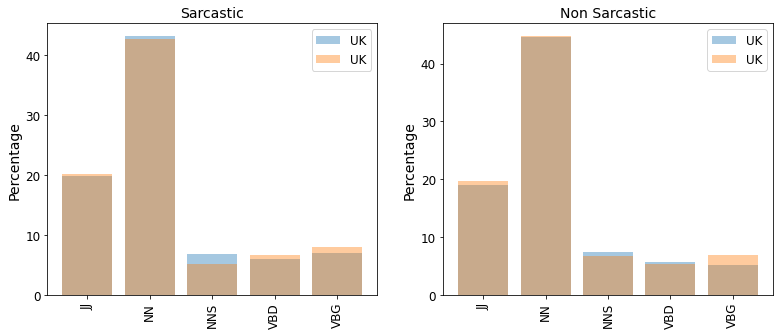

In [176]:
UK_s_keys = [x[0] for x in POScounter_sarcastic_uk if x[1] > 5]
UK_s_vals = [x[1] for x in POScounter_sarcastic_uk if x[1] > 5]

US_s_keys = [x[0] for x in POScounter_sarcastic_us if x[1] > 5]
US_s_vals = [x[1] for x in POScounter_sarcastic_us if x[1] > 5]

UK_ns_keys = [x[0] for x in POScounter_nonsarcastic_uk if x[1] > 5]
UK_ns_vals = [x[1] for x in POScounter_nonsarcastic_uk if x[1] > 5]

US_ns_keys = [x[0] for x in POScounter_nonsarcastic_us if x[1] > 5]
US_ns_vals = [x[1] for x in POScounter_nonsarcastic_us if x[1] > 5]

fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].bar(UK_s_keys, UK_s_vals, alpha = 0.4, label = 'UK')
ax[0].bar(US_s_keys, US_s_vals, alpha = 0.4, label = 'UK')

ax[1].bar(UK_ns_keys, UK_ns_vals, alpha = 0.4, label = 'UK')
ax[1].bar(US_ns_keys, US_ns_vals, alpha = 0.4, label = 'UK')

ax[0].legend()
ax[1].legend()

ax[0].title.set_text('Sarcastic')
ax[1].title.set_text('Non Sarcastic')

ax[0].set_ylabel('Percentage')
ax[1].set_ylabel('Percentage')

ax[0].tick_params(axis='x', labelrotation = 90)
ax[1].tick_params(axis='x', labelrotation = 90)

plt.show()

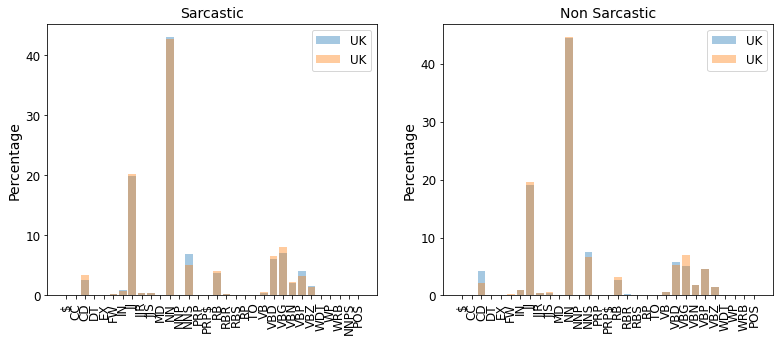

In [178]:
UK_s_keys = [x[0] for x in POScounter_sarcastic_uk]
UK_s_vals = [x[1] for x in POScounter_sarcastic_uk]

US_s_keys = [x[0] for x in POScounter_sarcastic_us]
US_s_vals = [x[1] for x in POScounter_sarcastic_us]

UK_ns_keys = [x[0] for x in POScounter_nonsarcastic_uk]
UK_ns_vals = [x[1] for x in POScounter_nonsarcastic_uk]

US_ns_keys = [x[0] for x in POScounter_nonsarcastic_us]
US_ns_vals = [x[1] for x in POScounter_nonsarcastic_us]

fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].bar(UK_s_keys, UK_s_vals, alpha = 0.4, label = 'UK')
ax[0].bar(US_s_keys, US_s_vals, alpha = 0.4, label = 'UK')

ax[1].bar(UK_ns_keys, UK_ns_vals, alpha = 0.4, label = 'UK')
ax[1].bar(US_ns_keys, US_ns_vals, alpha = 0.4, label = 'UK')

ax[0].legend()
ax[1].legend()

ax[0].title.set_text('Sarcastic')
ax[1].title.set_text('Non Sarcastic')

ax[0].set_ylabel('Percentage')
ax[1].set_ylabel('Percentage')

ax[0].tick_params(axis='x', labelrotation = 90)
ax[1].tick_params(axis='x', labelrotation = 90)

plt.show()

In [206]:
def aggregate_tags(list_of_tags):
    result = {
        'nouns': 0,
        'verbs': 0,
        'adjective': 0,
        'preposition': 0,
        'pronoun': 0,
        # 'articles': 0,
        'adverb': 0,
        'other': 0
    }
    
    for key, val in list_of_tags:
        if key in ['JJ', 'JJR', 'JJS']:
            result.update({'adjective': result['adjective']+val})
        elif key in ['NN', 'NNS', 'NNP', 'NNPS']:
            result.update({'nouns': result['nouns']+val})
        elif key in ['VB','VBD','VBG','VBN','VBP','VBZ']:
            result.update({'verbs': result['verbs']+val})
        elif key in ['RB','RBR','RBS']:
            result.update({'adverb': result['adverb']+val})
        elif key in ['IN']:
            result.update({'preposition': result['preposition']+val})
        elif key in ['PRP', 'PRP$', 'WP', 'WP$']:
            result.update({'pronoun': result['pronoun']+val})
        else:
            result.update({'other': result['other']+val})

    return result

In [208]:
UK_s = aggregate_tags(POScounter_sarcastic_uk)
US_s = aggregate_tags(POScounter_sarcastic_us)
UK_ns = aggregate_tags(POScounter_nonsarcastic_uk)
US_ns = aggregate_tags(POScounter_nonsarcastic_us)

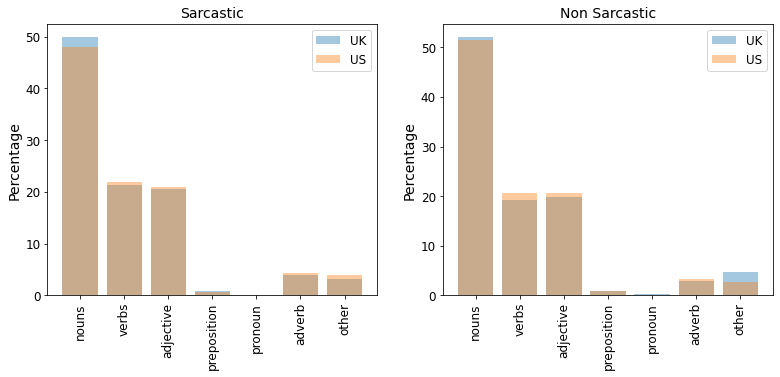

In [211]:
fig, ax = plt.subplots(1, 2, figsize=(13,5))
ax[0].bar(UK_s.keys(), UK_s.values(), alpha = 0.4, label = 'UK')
ax[0].bar(US_s.keys(), US_s.values(), alpha = 0.4, label = 'US')

ax[1].bar(UK_ns.keys(), UK_ns.values(), alpha = 0.4, label = 'UK')
ax[1].bar(US_ns.keys(), US_ns.values(), alpha = 0.4, label = 'US')

ax[0].legend()
ax[1].legend()

ax[0].title.set_text('Sarcastic')
ax[1].title.set_text('Non Sarcastic')

ax[0].set_ylabel('Percentage')
ax[1].set_ylabel('Percentage')

ax[0].tick_params(axis='x', labelrotation = 90)
ax[1].tick_params(axis='x', labelrotation = 90)

plt.show()

In [207]:
aggregate_tags(POScounter_nonsarcastic_uk)

{'nouns': 52.1616781785623,
 'verbs': 19.280293340155197,
 'adjective': 19.8857337767545,
 'preposition': 0.9635883005031124,
 'pronoun': 0.18760126204485378,
 'adverb': 2.8140189306728063,
 'other': 4.707086211307239}

# T-SNE

/Users/pafitis/miniforge3/envs/comp0087/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


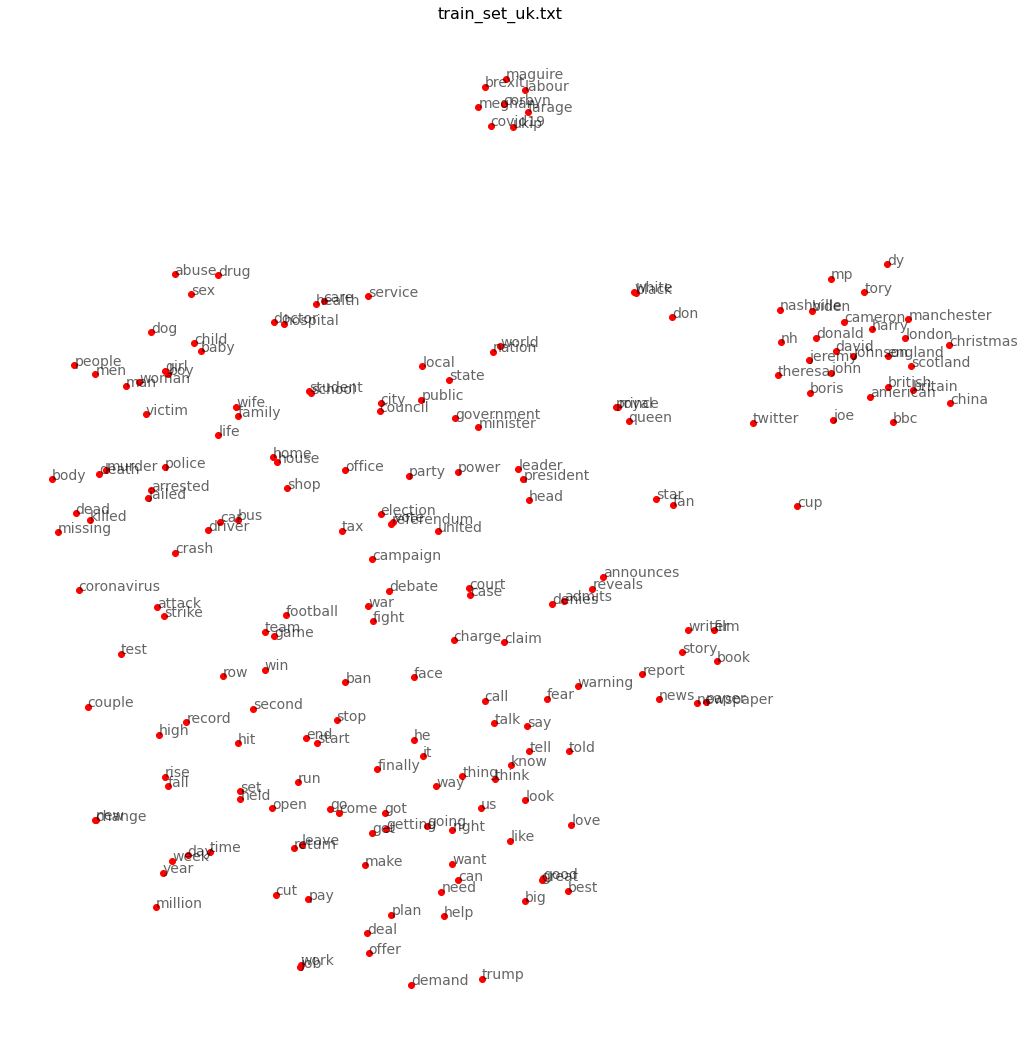

In [11]:
textfile =  "../datasets/glove/train_set_uk.txt"
most_common_words, embeddings = word2vec_embeddings(textfile)
plot_tsne(most_common_words, embeddings, 'train_set_uk.txt')

/Users/pafitis/miniforge3/envs/comp0087/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


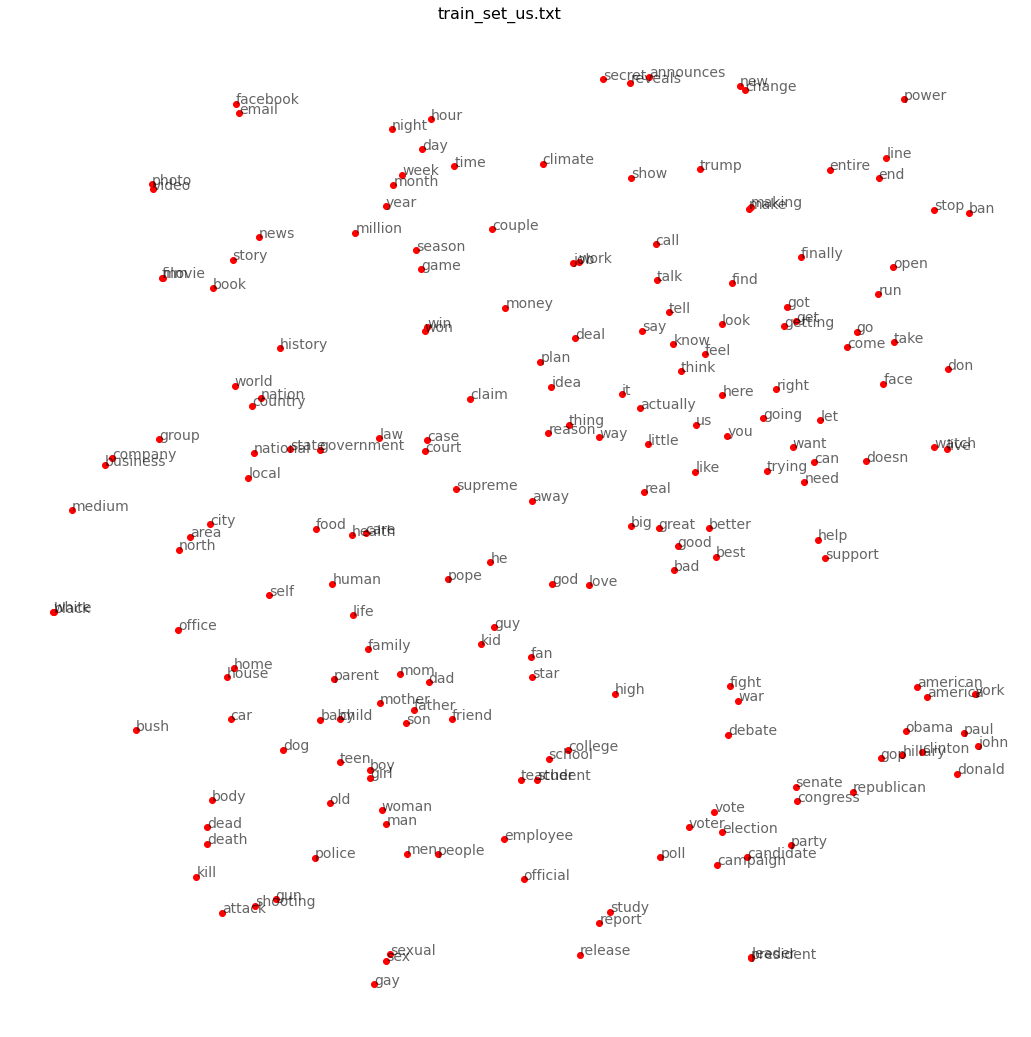

In [36]:
textfile =  "../datasets/glove/train_set_us.txt"
most_common_words, embeddings = word2vec_embeddings(textfile)
plot_tsne(most_common_words, embeddings, 'train_set_us.txt')

/Users/pafitis/miniforge3/envs/comp0087/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


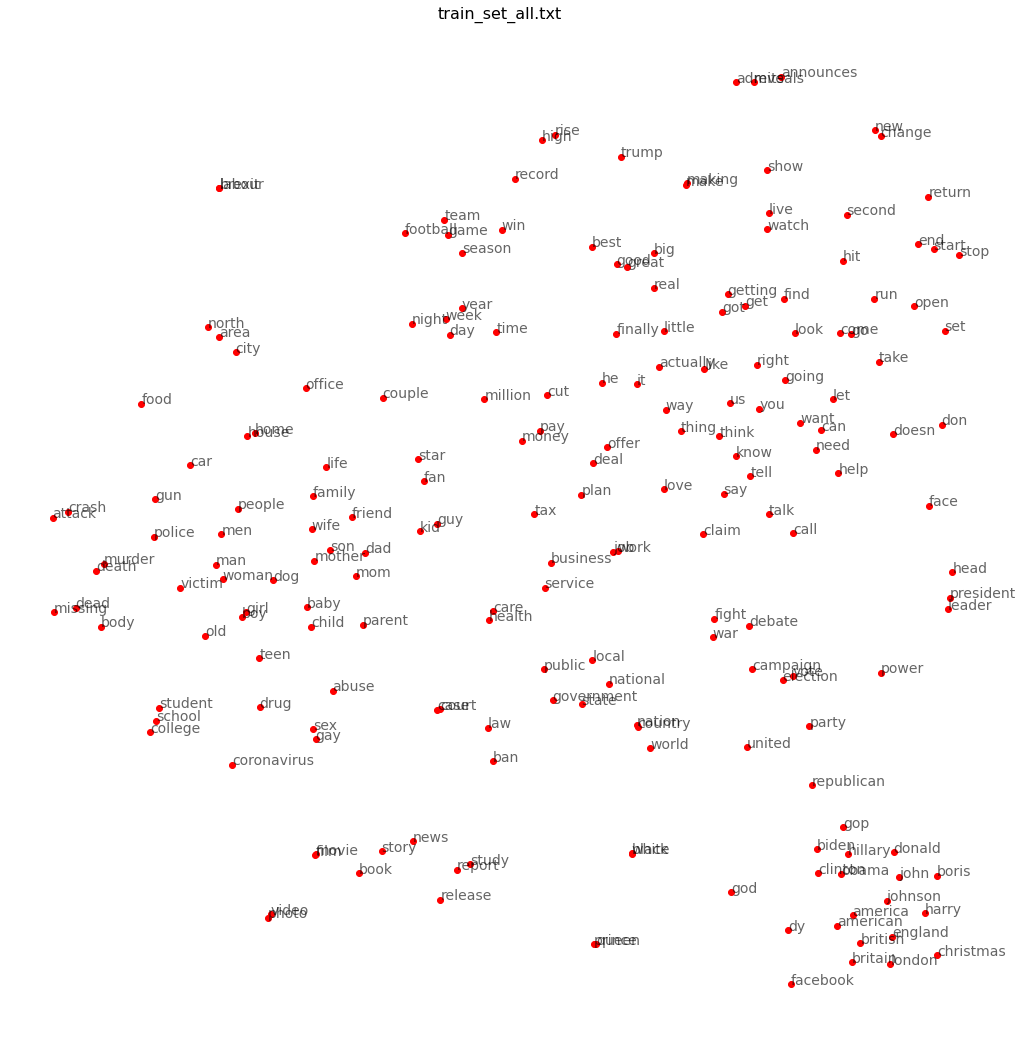

In [37]:
textfile =  "../datasets/glove/train_set_all.txt"
most_common_words, embeddings = word2vec_embeddings(textfile)
plot_tsne(most_common_words, embeddings, 'train_set_all.txt')

/Users/pafitis/miniforge3/envs/comp0087/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


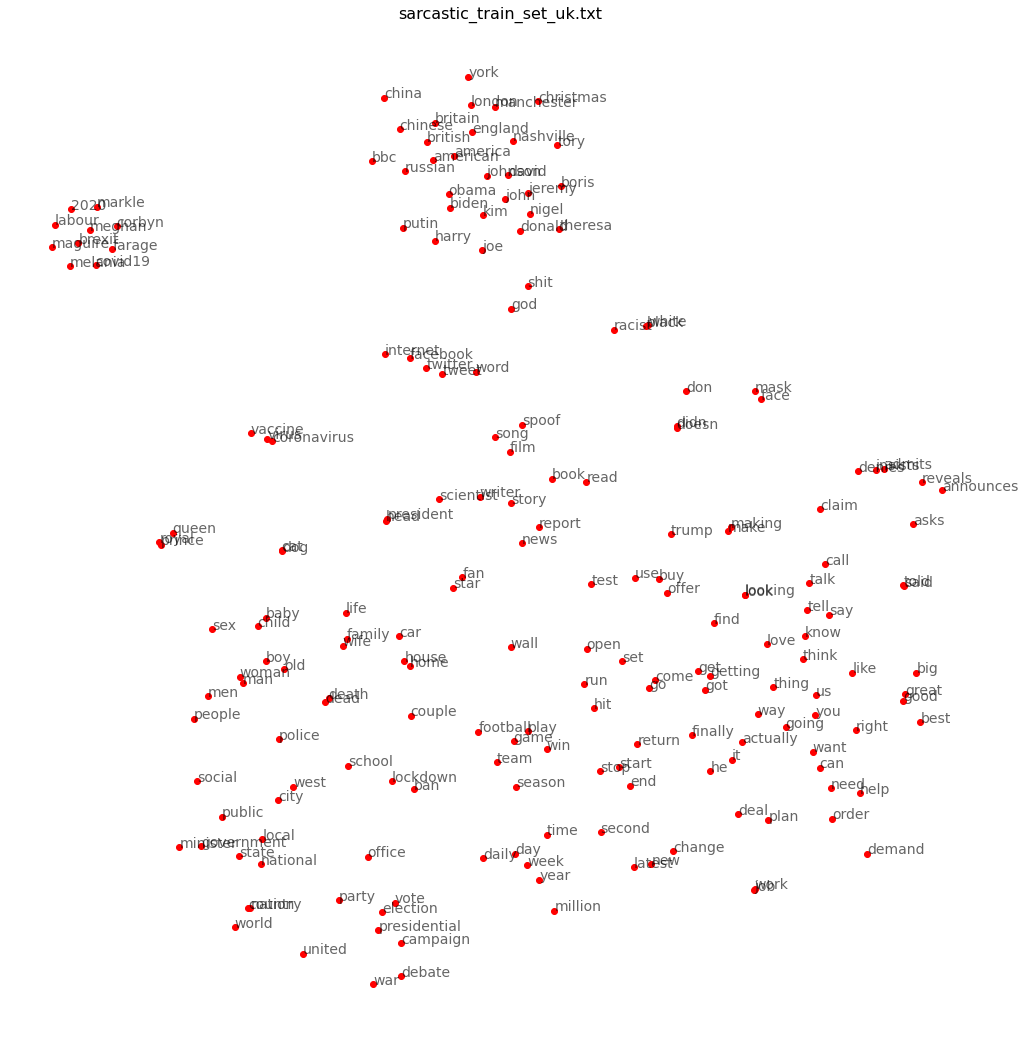

In [38]:
textfile =  "../datasets/glove/sarcastic_train_set_uk.txt"
most_common_words, embeddings = word2vec_embeddings(textfile)
plot_tsne(most_common_words, embeddings, 'sarcastic_train_set_uk.txt')

/Users/pafitis/miniforge3/envs/comp0087/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


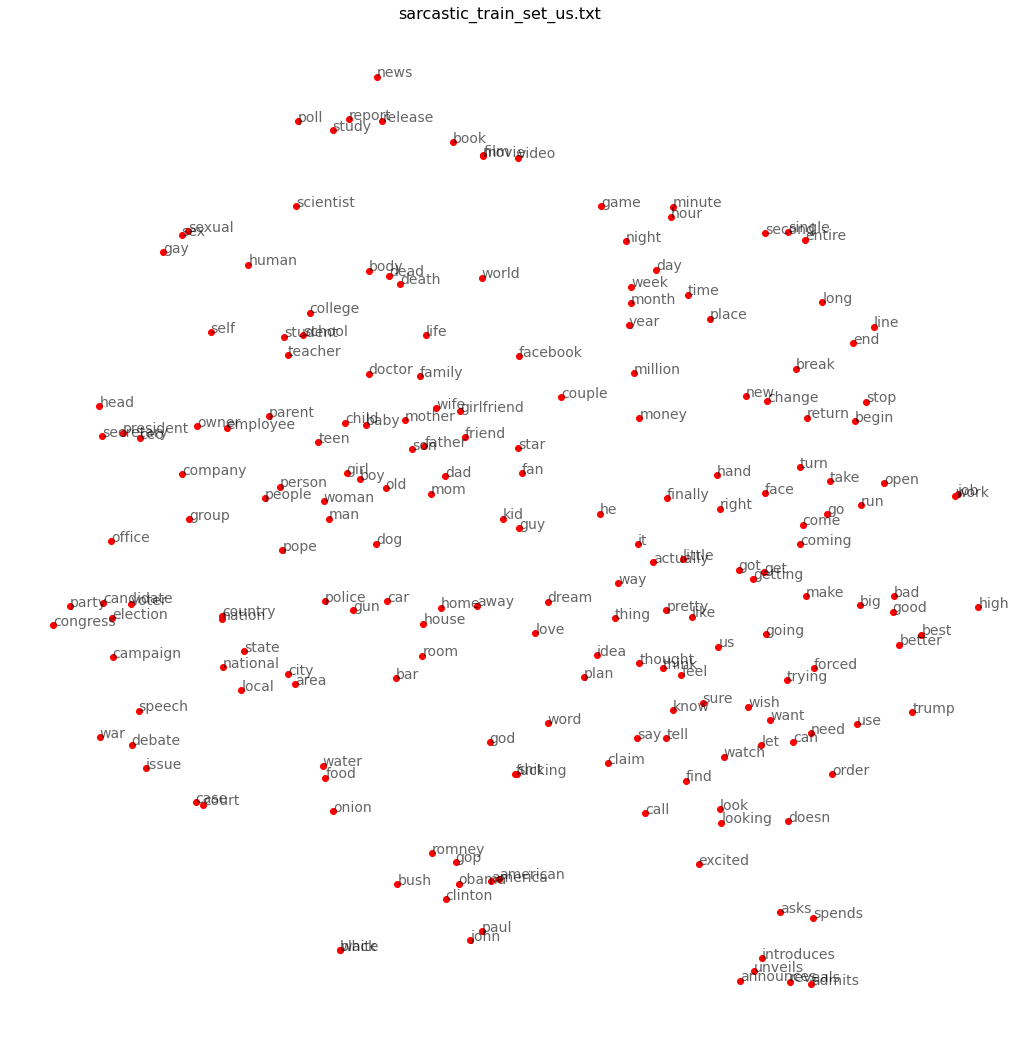

In [39]:
textfile =  "../datasets/glove/sarcastic_train_set_us.txt"
most_common_words, embeddings = word2vec_embeddings(textfile)
plot_tsne(most_common_words, embeddings, 'sarcastic_train_set_us.txt')

/Users/pafitis/miniforge3/envs/comp0087/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


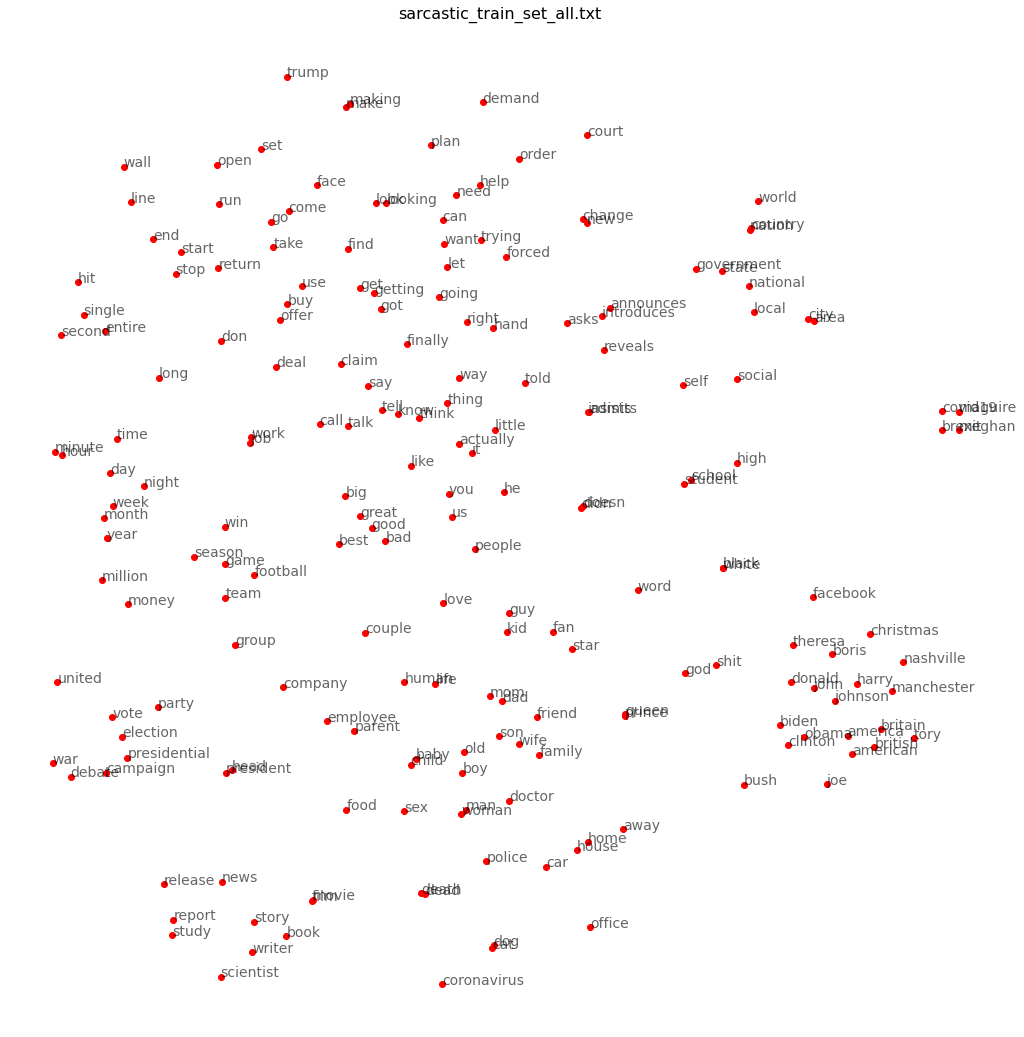

In [40]:
textfile =  "../datasets/glove/sarcastic_train_set_all.txt"
most_common_words, embeddings = word2vec_embeddings(textfile)
plot_tsne(most_common_words, embeddings, 'sarcastic_train_set_all.txt')

/Users/pafitis/miniforge3/envs/comp0087/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


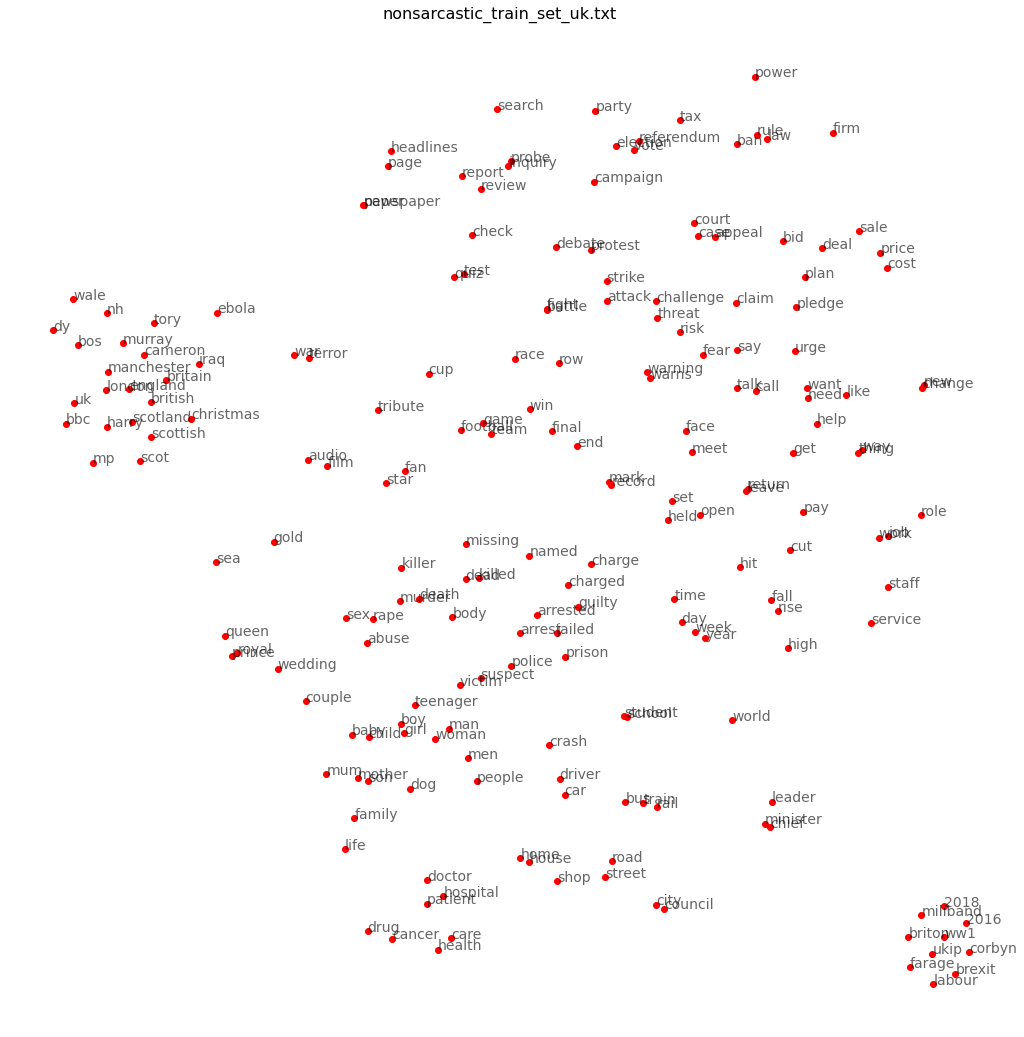

In [41]:
textfile =  "../datasets/glove/nonsarcastic_train_set_uk.txt"
most_common_words, embeddings = word2vec_embeddings(textfile)
plot_tsne(most_common_words, embeddings, 'nonsarcastic_train_set_uk.txt')

/Users/pafitis/miniforge3/envs/comp0087/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


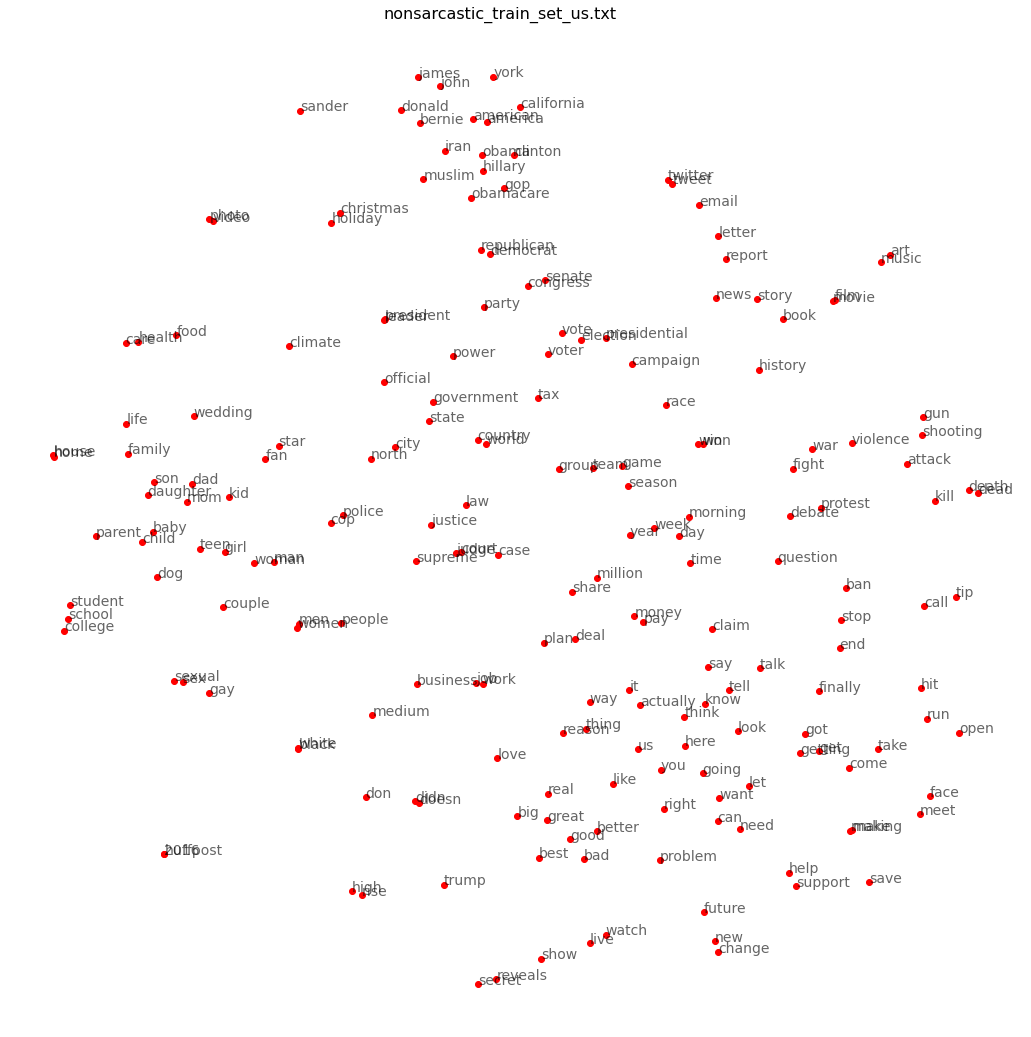

In [42]:
textfile =  "../datasets/glove/nonsarcastic_train_set_us.txt"
most_common_words, embeddings = word2vec_embeddings(textfile)
plot_tsne(most_common_words, embeddings, 'nonsarcastic_train_set_us.txt')

/Users/pafitis/miniforge3/envs/comp0087/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


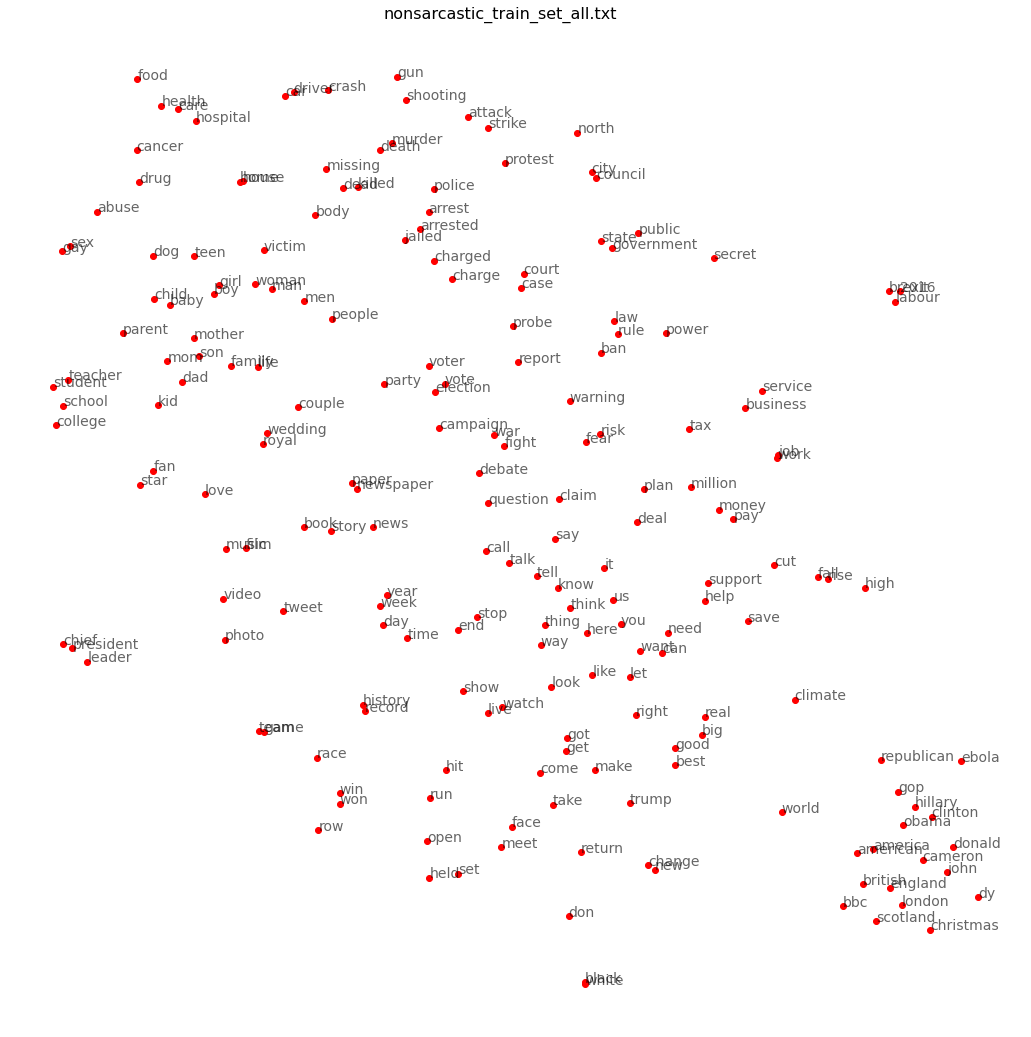

In [43]:
textfile =  "../datasets/glove/nonsarcastic_train_set_all.txt"
most_common_words, embeddings = word2vec_embeddings(textfile)
plot_tsne(most_common_words, embeddings, 'nonsarcastic_train_set_all.txt')